In [1]:
from astropy.table import Table, Column
import time
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
from scipy.stats import kde
from tqdm import tqdm
sys.path.insert(0, '/home/reza/erq/')
from erqml import *
import sys
sys.path.insert(0, '/home/reza/erq')
from scipy import interpolate
# import pyfits
from numpy import *
import math
import scipy.ndimage
from scipy import interpolate
from numpy import nanmean
from numpy import nanmedian
from readSDSSspectrafast import *
import matplotlib.pylab as plt
import numpy as np
from erqml import *
from scipy import ndimage
from line_db import line_db
import os
# Reading data
# smp=Table.read('/home/reza/erq/sampling/org_sample2.fits')
smp=Table.read('/home/reza/erq/sampling/LM_sample.fits')
W3_0=smp['ABw3']
iW3_0 = smp['i-w3']
kt80_0= smp['kurt80_gf']
rew_0 = smp['rew_gf']
rew_0  = np.log10(rew_0)
frat_0 = smp['frat_nv/civ']
fwhm_0 = smp['fwhm_gf']
rw3_0=smp['r-w3']
rz_0=smp['r-z']
iz_0 = iW3_0 - rw3_0 + rz_0
Lum_0 = smp['Lum']
z_dr12=smp['z_dr12']
nqsos_0=len(iW3_0)
plate_0 = smp['Plate']
mjd_0 = smp['MJD']
fiberid_0= smp['FiberID']
# smp.columns


/home/reza/anaconda3/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
len(iW3_0[(iW3_0>=4.6) &(rew_0>=2)])

74

In [3]:
#  ---------r-z sample
z_cut = 2.8
W3_rz= W3_0[z_dr12<=z_cut]
iW3_rz = iW3_0[z_dr12<=z_cut]
kt80_rz= kt80_0[z_dr12<=z_cut]
rew_rz = rew_0[z_dr12<=z_cut]
frat_rz = frat_0[z_dr12<=z_cut]
fwhm_rz = fwhm_0[z_dr12<=z_cut]
rw3_rz=rw3_0[z_dr12<=z_cut]
rz_rz=rz_0[z_dr12<=z_cut]
iz_rz = iW3_rz - rw3_rz + rz_rz
Lum_rz = Lum_0[z_dr12<=z_cut]
plate_rz = plate_0[z_dr12<=z_cut]
mjd_rz = mjd_0[z_dr12<=z_cut]
fiberid_rz=fiberid_0[z_dr12<=z_cut]
nqsos_rz=len(iW3_rz)
print(nqsos_0-nqsos_rz)
# smp.columns

6847


In [4]:
5900/1550-1
nqsos_rz

23739

In [5]:

X = np.array(list(zip(rz_rz, rew_rz)))
X_sc, s, m = MinMaxScaler(X)


In [6]:
from sklearn import svm
from sklearn.cluster import AgglomerativeClustering
ERQ_rz_sc = X_sc[((iW3_rz>=4.6) & (rew_rz>=2))]
ERQ_rz = X[((iW3_rz>=4.6) & (rew_rz>=2))]
len(ERQ_rz_sc)



56

In [ ]:
for link in [  'average']:
    for ncl in [4,5,6,7,8]:
        print(ncl, link)
        model = AgglomerativeClustering(n_clusters=ncl, linkage=link, affinity='euclidean').fit(X_sc)
        labels = model.labels_
        colors = ['C0', 'C1', 'C2','C3', 'C4', 'C5', 'C6', 'C7', 'C8']
        color_code=[]
        for i in range(len(X_sc)):
                color_code.append(colors[labels[i]])
        fg = plt.figure()
#         ax = Axes3D(fg)
#         ax.scatter(X[:,0], X[:,1], X[:,2],  c=color_code, alpha=0.7, s=2)
        plt.scatter(X[:,0], X[:,1],  c=color_code, alpha=0.7, s=2)
        plt.scatter(ERQ_rz[:,0], ERQ_rz[:,1],  facecolor='none', edgecolor='black', 
                    s=20, label='ERQ')
        plt.xlabel('i-w3')
        plt.ylabel('r-z')
#         plt.axvline(x=4.6, ymin=0.6)
#         plt.axhline(y=2, xmin=0.6)
        plt.legend()
        plt.title(link + '-linkage'+ ', ncl: %d' %ncl + ', z<=%.2f'%z_cut)
        plt.savefig('2d-rz-rew/2d-rz-iw3-ncl-%d-link-%s-z_cut-%.2f.pdf' %(ncl, link, z_cut), 
                    format='pdf', dpi=1200, bbox_inches='tight')
        plt.show()

4 average


In [ ]:
# Med-spec of clusters 
# -------------Med-Spec---------------------------------
## Define a log wavelength grid for the composite spectrum
step = 1.00015
bb = arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)
nqsos = len(z_dr12)
link='average'
for ncl in [8]:
    print('n-cls:',ncl)
    cl_pop = np.zeros([ncl])
    model = AgglomerativeClustering(n_clusters=ncl, linkage=link, affinity='euclidean').fit(X_tr)
    labels = model.labels_
    
    for cl_label in range(ncl):
        
            cl_pop[cl_label] = len(labels[labels==cl_label])
            print('cl_label:', cl_label, 'cl_pop:', cl_pop[cl_label])

            sp = zeros([int(cl_pop[cl_label]), nw])
            k=-1
            for i in tqdm(range(len(labels))):
                if(labels[i]==cl_label):
                    k+=1
                # Retrieve the spectra:
                    file = '/home/reza/erq/fred/sdss/%d/spec-%d-%d-%04d.fits' \
                    % (plate_rz[i], plate_rz[i],mjd_rz[i],fiberid_rz[i])
                    spec = readDR10spec(file)
                    wave = spec['wl']
                    wz = wave/(z_dr12[i]+1)
                    flux = spec['flux']
                    mask = (wz > 1680.0) & (wz < 1730.0)
                    fnorm = median(flux[mask])
                    fluxn = flux/fnorm
                # interpolate the rest-frame spectrum onto the standard grid
                    f = interpolate.interp1d(wz,fluxn,bounds_error=False,fill_value=float('nan'))
                    sp[k] = f(wgrid)
                # calculate the median spectrum

            med1 = nanmedian(sp,axis=0)
            savetxt( '2d-rz-iw3/agg-medspec-nCl-%d-cl_label-%d.txt' %(ncl, cl_label), med1)
    np.savetxt('2d-rz-iw3/labels-ncl-%d.txt'%ncl, labels)    
    np.savetxt('2d-rz-iw3/cluster_pop-ncl-%d.txt'%ncl, cl_pop)

n-cls: 8


  0%|          | 1/23739 [00:00<48:02,  8.23it/s]

cl_label: 0 cl_pop: 23333.0


 33%|███▎      | 7855/23739 [14:03<27:48,  9.52it/s] 

n-cls: 6


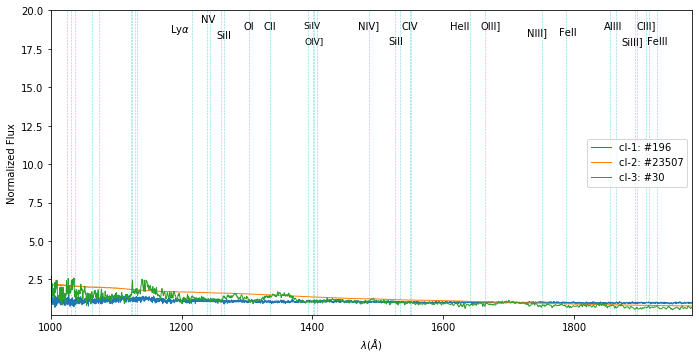

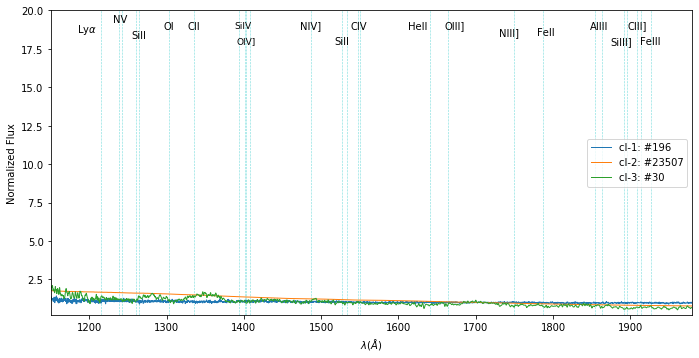

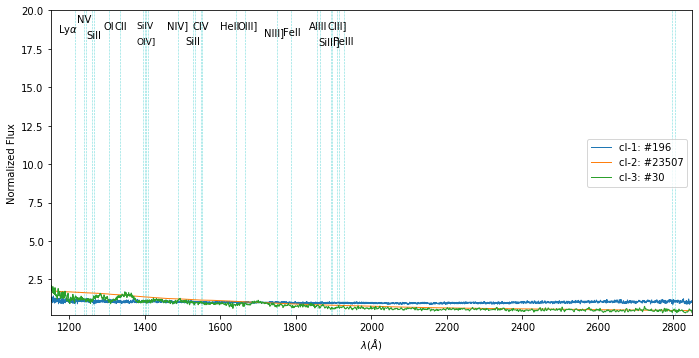

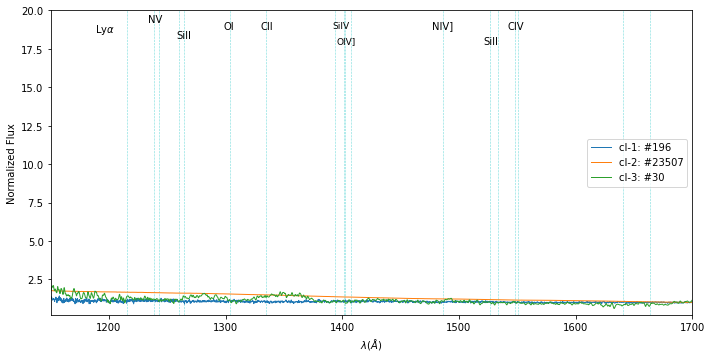

In [16]:
#  ----------------2d plot-----------------

## Define a log wavelength grid for the composite spectrum
step = 1.00015
bb = arange(0,8813,1)
wgrid = 800.0 * step**bb

# Insert code here to read data for all possible quasars (redshift, colors, line data, etc.)

from astropy.table import Table, Column
nqsos = len(z_dr12)
c=['C0', 'C1', 'C2','C3', 'C4', 'C5', 'C6', 'C7',  'C8']
j=0
ymax=20
ymin=0.01*ymax
fs=10; fs1=9
y_median = 0.93*ymax
med_step=0.7
for ncl in [6]:
    print('n-cls:',ncl)
    cl_pop =    np.loadtxt('2d-rz-iw3/cluster_pop-ncl-%d.txt'%ncl)
    labels =  np.loadtxt('2d-rz-iw3/labels-ncl-%d.txt'%ncl) 

    
    for ii in range(0,4):

        if(ii==0): lambda_min = 1000; lambda_max = 1980
        if(ii==1): lambda_min = 1150; lambda_max = 1980
        if(ii==2): lambda_min = 1150; lambda_max = 2850
        if(ii==3): lambda_min = 1150; lambda_max = 1700
        fig = plt.figure(figsize=(11.5,5.6))

        line_db(ymax, fs, fs1, ii)
        plt.ylim(ymin,ymax)
        plt.xlim(lambda_min, lambda_max)
        yb=0
        x_median=lambda_min+100

        for cl_label in range(ncl):
            if (cl_pop[cl_label]>=10):
                yb+=1
#                 print('Cl:', cl_label, lambda_min, 'to', lambda_max)

                med1=loadtxt('2d-rz-iw3/agg-medspec-nCl-%d-cl_label-%d.txt' %(ncl, cl_label))
                plt.ylabel('Normalized Flux')
                plt.xlabel(r'$\lambda  (\AA)$')
                w3_bin = W3_rz[labels==cl_label] 
                imw3_bin = iW3_rz[labels==cl_label]
                REW_bin =10**rew_rz[labels==cl_label]
                fwhm_bin = fwhm_rz[labels==cl_label]
                kt80_bin = kt80_rz[labels==cl_label]
                frat_bin = frat_rz[labels==cl_label]
                iz_bin = iz_rz[labels==cl_label]
                Lum_bin  = Lum_rz[labels==cl_label]
                if(cl_pop[cl_label]<100):
                    sm_med1 = ndimage.filters.gaussian_filter1d(med1,2.0)
                else:
                    sm_med1=med1

                # masking for plot ranges
                ind = (wgrid>lambda_min) & (wgrid<lambda_max)
                plt.plot(wgrid[ind],  sm_med1[ind], lw = 1,  c=c[cl_label],
                         label='cl-%d: #%d' %(cl_label+1, cl_pop[cl_label]))
#                 plt.text(x_median, y_median -(yb+1)*med_step,
#                              'clustr-%d  #%d,    i-w3=%.1f,   REW=%d,   FWHM=%d,   kt80=%.2f,   Nv/Civ=%.2f,   i-z=%.1f' 
#                              %(cl_label+1, cl_pop[cl_label], np.median(imw3_bin),  
#                                 np.median(REW_bin), np.median(fwhm_bin),  
#                                 np.median(kt80_bin), np.median(frat_bin), 
#                                 np.median(iz_bin)), 
#                              ha='left', va='center', color=c[cl_label], fontsize=10)
            plt.legend(loc=7)

            plt.savefig('2d-rz-iw3/med-spec/2d-agg-nCl-%d-med-spec-%d-%d.pdf' %(ncl,  lambda_min, lambda_max), format='pdf',  bbox_inches='tight')

In [ ]:
!ls


In [ ]:
!mkdir 2d-rz-iw3/med-spec